# Downscaling part II

- Forest-based method  
- Downscaling emission using forest loss country-level / region-level 
- Downscaling seq using forest gain country-level / region-level

In [1]:
# libraries

## data wraggling
import os
import pandas as pd
import numpy as np
import xarray as xr

## geospatial data wraggling
import geopandas as gpd
import regionmask
import rioxarray
import rasterio

## plotting
import matplotlib
import matplotlib.pyplot as plt
from rasterio.plot import show
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
os.getcwd()

'/Users/firzariany/Documents/ikea_land_use/unstaged_scripts'

Datasets are sourced from a box folder

In [4]:
# gridded data to map forest distribution
path = "/Users/firzariany/Box/Climate Policy Team/02 - Projects/IKEA NDC 1.5° Pathways 20-22/2- Work Packages/WP3 -  LULUCF Pathways/Workflow/Data/IMAGE_SSPs/"

file = path + "SSP1s_july2021/SSP1_SPA0_19I_LIRE_LB/GLANDCOVER_30MIN.NC"

# rioxarray.open_rasterio
df_19 = (xr.open_dataset(file))

In [5]:
# df_19

In [6]:
# select land cover variable
glandcov_19 = df_19.GLANDCOVER_30MIN

In [7]:
# world border
b_file = path + "TM_WORLD_BORDERS-0"

regions = gpd.read_file(b_file)

In [8]:
# import garea, cell size
# path
area = (xr.open_rasterio(path + "GAREA_30M.asc"))

---
## Functions

In [9]:
# fun for land_type distribution
def dist_reg_2(variable, land_type, date, reg_name):
    dist_df = variable.sel(NGLNDCOV = land_type, time = date)
    dist_df = dist_df.rio.set_crs("epsg:4326")
    
    reg = reg_name
    g_reg = reg.geometry
    
    clipped = dist_df.rio.clip(g_reg, dist_df.rio.crs)
    
    return clipped

dist_reg_2 is used to get the distribution map of a certain land type (i.e. forest, agriculture, bioenergy) in a certain year.  
- variable refers to the land cover variable  
- land_type refers to the land cover band i.e. b'forest', b'cropland', b'pasture', etc.  
- date refers to a year  
- reg_name refers to the borders of the country of interest

The function returns an array containing the possibility of land type in each grid cell (0 - 1).

In [10]:
# fun to get the area of each land_type
def clipped_area(reg_name, reg_diff):
    
    global new_forests
    
    area_df = area.rio.set_crs("epsg:4326")
    reg = reg_name
    g_reg = reg.geometry
    area_clip = area_df.rio.clip(g_reg, area_df.rio.crs)
    
    # tidying the naming of lon/lat
    area_tidy = area_clip.rename({'y': 'lat', 'x': 'lon'})
    
    # calculate new forests' land  area
    new_forests =  reg_diff * area_tidy

clipped_area is used to calculate the land area for the above-mentioned land type based on the land-type's distribution map within a certain country's border in a certain year. The function takes the distribution map as the important input and clips the global land area map to the country's border which information is given in reg_name.  
- reg_name refers to the borders of the country of interest  
- reg_diff refers to the country's land distribution map

The function returns an array with land area values in km2.

In [11]:
# function to calculate accumulative changes 
def acc_changes(df):
    df["acc_changes"] = ""
    
    for x in df.index:
        if x == 0:
            df.acc_changes.loc[x]= 0
        else:
            df.acc_changes.loc[x]= (df["Forest area (km2)"][x] - df["Forest area (km2)"][0])

acc_changes is used to calculate the accumulative forest (area) changes across the years, with 2005 as the baseline year. The calculation is based on the forest area in x-year subtracted with forest area in 2005. This adds a new column called "acc_changes" in the input df with units = km2.

In [12]:
# calculate gross_changes in forest area
def gross_changes(df):
    df["gross_changes"] = ""
    
    for x in df.index:
        if (x-1) < 0:
            df.gross_changes.loc[x]= 0
        else:
            df.gross_changes.loc[x]= (df["Forest area (km2)"][x] - df["Forest area (km2)"][x-1])

gross_changes is used to calculate the gross changes in forest area between one year and another. The calculation is based on the forest area in x-year subtracted with forest area in (x-year - 1). This adds a new column called "gross_changes" in the input df with units = km2.  
if the result from the calculation is negative, it is considered as gross loss (loss of forest area)  
if the result is positive, it is considered as gross gains (gains of forest area)  

In [13]:
# calculate net_changes
def net_changes(df):
    df["net_changes"] = ""
    
    for x in df.index:
        if (x-1) < 0:
            df.net_changes.loc[x]= 0
        else:
            df.net_changes.loc[x]= (df["gross_changes"][x] + df["gross_changes"][x-1])

to be revised, not used yet

---

## Indonesia (country): Forest area

In [14]:
indo_cntry = regions[regions.ISO3 == "IDN"]

In [15]:
years=[]
for x in glandcov_19.time.values:
    years.append(x)

In [16]:
# iterate through the years to get forest distribution
dist_idn = []
for year in years:
    dist_yearly = dist_reg_2(variable=glandcov_19, land_type=b'forest                                            ',
                             date=year, reg_name=indo_cntry)
    dist_idn.append(dist_yearly)

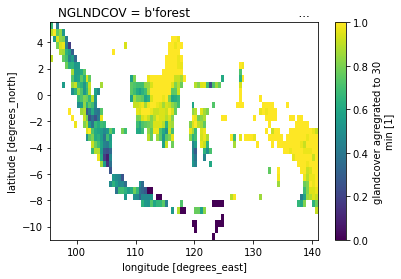

In [17]:
# to plot distribution
dist_idn[0].plot()

In [18]:
# the year
dist_idn[0].time

<xarray.DataArray 'time' ()>
array('1970-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    NGLNDCOV     |S50 b'forest                                            '
    time         datetime64[ns] 1970-01-01
    spatial_ref  int64 0
Attributes:
    standard_name:  time
    calender:       gregorian

In [19]:
# iterate through the dist_indo list to get the area
idn_area = []
for num in range(len(dist_idn)):
    area_idn = clipped_area(reg_name=indo_cntry, reg_diff=dist_idn[num])
    idn_area.append(new_forests)

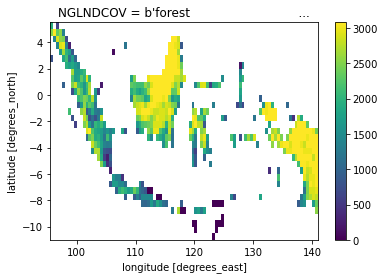

In [20]:
# to plot forest area
idn_area[0].plot()

In [21]:
# the year
idn_area[0].time

<xarray.DataArray 'time' ()>
array('1970-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    NGLNDCOV     |S50 b'forest                                            '
    time         datetime64[ns] 1970-01-01
    spatial_ref  int64 0
Attributes:
    standard_name:  time
    calender:       gregorian

In [22]:
# get area values
vals_idn_area = []
for num in range(len(idn_area)):
    vals_idn_area.append(idn_area[num].sum().values)

In [23]:
# store the values in a dataset
data = {"Region" : ["INDO"]*27, "Years" : years, "Forest area (km2)" : vals_idn_area}
forest_idn = pd.DataFrame(data)

In [24]:
# subset to data after 2005
forest_idn_2005 = (forest_idn.loc[forest_idn.Years >= "2005-01-01"]
                   .reset_index(drop=True)
                   .astype({'Forest area (km2)': 'float32'}))

In [25]:
# accumulated changes
acc_changes(df=forest_idn_2005)

/Users/firzariany/opt/anaconda3/envs/land_1o5_2/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [26]:
# here's how I calculate the gross changes in forest area
gross_changes(df=forest_idn_2005)

In [23]:
# net_changes(df=forest_idn_2005)

In [27]:
forest_idn_2005.head()

Region      Years  Forest area (km2) acc_changes gross_changes
0   INDO 2005-01-01       1.082992e+06           0             0
1   INDO 2010-01-01       1.045839e+06 -37153.3125   -37153.3125
2   INDO 2015-01-01       1.015898e+06  -67093.625   -29940.3125
3   INDO 2020-01-01       9.937669e+05  -89225.125      -22131.5
4   INDO 2025-01-01       9.930754e+05  -89916.625        -691.5

In [28]:
# subset for losses and gains
loss_idn = forest_idn_2005.loc[forest_idn_2005.gross_changes <= 0]
gains_idn = forest_idn_2005.loc[forest_idn_2005.gross_changes >= 0]

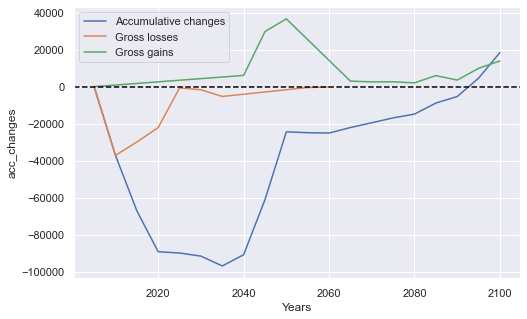

In [29]:
# plotting net and gross changes
sns.set_theme()
plt.figure(figsize=[8,5])
sns.lineplot(data=forest_idn_2005, x="Years", y="acc_changes", label="Accumulative changes")
# sns.lineplot(data=forest_idn_2005, x="Years", y="net_changes", label="Net forest changes")
sns.lineplot(data=loss_idn, x="Years", y="gross_changes", label="Gross losses")
sns.lineplot(data=gains_idn, x="Years", y="gross_changes", label="Gross gains")
plt.axhline(0, ls='--', c="black");

## Papua New Guinea: Forest area

In [32]:
png = regions[regions.ISO3 == "PNG"]

In [33]:
# iterate through the years to get forest distribution
dist_png = []
for year in years:
    dist_yearly = dist_reg_2(variable=glandcov_19, land_type=b'forest                                            ',
                             date=year, reg_name=png)
    dist_png.append(dist_yearly)

In [34]:
# iterate through the dist_indo list to get the area
png_area = []
for num in range(len(dist_png)):
    area_png = clipped_area(reg_name=png, reg_diff=dist_png[num])
    png_area.append(new_forests)

In [35]:
# get the values
vals_png_area = []
for num in range(len(png_area)):
    vals_png_area.append(png_area[num].sum().values)

In [36]:
# store the values in a dataset
data = {"Region" : ["PNG"]*27, "Years" : years, "Forest area (km2)" : vals_png_area}
forest_png = pd.DataFrame(data)

In [37]:
# subset to data after 2005
forest_png_2005 = (forest_png.loc[forest_png.Years >= "2005-01-01"]
                   .reset_index(drop=True)
                   .astype({'Forest area (km2)': 'float32'}))

In [38]:
# calculate accumulative changes
acc_changes(df=forest_png_2005)

/Users/firzariany/opt/anaconda3/envs/land_1o5_2/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [39]:
# calculate gross_changes
gross_changes(df=forest_png_2005)

In [40]:
net_changes(df=forest_png_2005)

In [41]:
forest_png_2005.head()

Region      Years  Forest area (km2) acc_changes gross_changes net_changes
0    PNG 2005-01-01       360872.21875           0             0           0
1    PNG 2010-01-01       360276.06250  -596.15625    -596.15625  -596.15625
2    PNG 2015-01-01       359764.96875    -1107.25    -511.09375    -1107.25
3    PNG 2020-01-01       359735.90625  -1136.3125      -29.0625  -540.15625
4    PNG 2025-01-01       361134.50000   262.28125    1398.59375  1369.53125

In [42]:
# subset for losses and gains
loss_png = forest_png_2005.loc[forest_png_2005.gross_changes <= 0]
gains_png = forest_png_2005.loc[forest_png_2005.gross_changes >= 0]

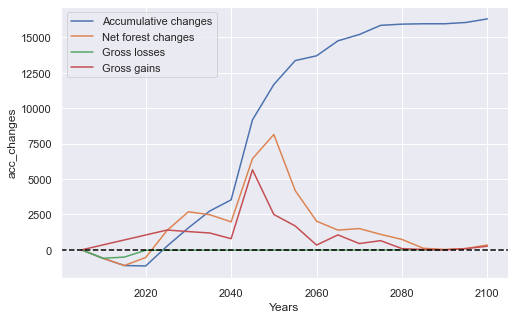

In [43]:
# plotting net and gross changes
plt.figure(figsize=[8,5])
sns.lineplot(data=forest_png_2005, x="Years", y="acc_changes", label="Accumulative changes")
sns.lineplot(data=forest_png_2005, x="Years", y="net_changes", label="Net forest changes")
sns.lineplot(data=loss_png, x="Years", y="gross_changes", label="Gross losses")
sns.lineplot(data=gains_png, x="Years", y="gross_changes", label="Gross gains")
plt.axhline(0, ls='--', c="black");

## East Timor: forest area

In [46]:
tls = regions[regions.ISO3 == "TLS"]

In [47]:
# iterate through the years to get forest distribution
dist_tls = []
for year in years:
    dist_yearly = dist_reg_2(variable=glandcov_19, land_type=b'forest                                            ',
                             date=year, reg_name=tls)
    dist_tls.append(dist_yearly)

In [48]:
# iterate through the dist_indo list to get the area
tls_area = []
for num in range(len(dist_tls)):
    area_tls = clipped_area(reg_name=tls, reg_diff=dist_tls[num])
    tls_area.append(new_forests)

In [49]:
# get the values
vals_tls_area = []
for num in range(len(tls_area)):
    vals_tls_area.append(tls_area[num].sum().values)

In [50]:
# store the values in a dataset
data = {"Region" : ["TLS"]*27, "Years" : years, "Forest area (km2)" : vals_tls_area}
forest_tls = pd.DataFrame(data)

In [51]:
# subset to data after 2005
forest_tls_2005 = (forest_tls.loc[forest_tls.Years >= "2005-01-01"]
                   .reset_index(drop=True)
                   .astype({'Forest area (km2)': 'float32'}))

In [52]:
# calculate accumulative changes
acc_changes(df=forest_tls_2005)

/Users/firzariany/opt/anaconda3/envs/land_1o5_2/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [53]:
# calculate gross_changes
gross_changes(df=forest_tls_2005)

In [54]:
net_changes(df=forest_tls_2005)

In [55]:
forest_tls_2005.head()

Region      Years  Forest area (km2) acc_changes gross_changes net_changes
0    TLS 2005-01-01         962.737427           0             0           0
1    TLS 2010-01-01         770.914673 -191.822754   -191.822754 -191.822754
2    TLS 2015-01-01         723.880859 -238.856567    -47.033813 -238.856567
3    TLS 2020-01-01         837.756165 -124.981262    113.875305   66.841492
4    TLS 2025-01-01         830.528931 -132.208496     -7.227234  106.648071

In [56]:
# subset for losses and gains
loss_tls = forest_tls_2005.loc[forest_tls_2005.gross_changes <= 0]
gains_tls = forest_tls_2005.loc[forest_tls_2005.gross_changes >= 0]

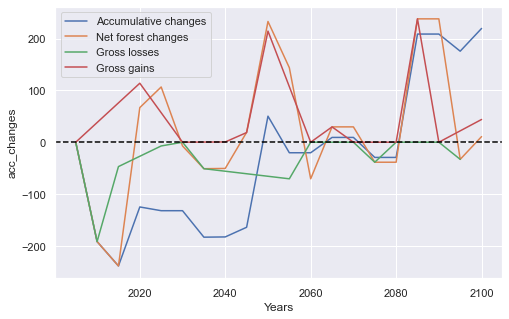

In [57]:
# plotting net and gross changes
plt.figure(figsize=[8,5])
sns.lineplot(data=forest_tls_2005, x="Years", y="acc_changes", label="Accumulative changes")
sns.lineplot(data=forest_tls_2005, x="Years", y="net_changes", label="Net forest changes")
sns.lineplot(data=loss_tls, x="Years", y="gross_changes", label="Gross losses")
sns.lineplot(data=gains_tls, x="Years", y="gross_changes", label="Gross gains")
plt.axhline(0, ls='--', c="black");

In [60]:
vals_tls_area[0]

array(6106.966, dtype=float32)

In [61]:
vals_idn_area[0] + vals_png_area[0] + vals_tls_area[0]

1717238.2

In [69]:
vals_idn_area[1] + vals_png_area[1] + vals_tls_area[1]

1728213.2

In [70]:
vals_area[1]

array(1728213.2, dtype=float32)

## Indonesian region: region-level forest changes

Including Indonesia, PNG, and East Timor

In [58]:
indo_reg = ["IDN", "PNG", "TLS"]
indo_reg= regions[regions.ISO3.isin(indo_reg)]

In [59]:
dist_indo = []
for year in years:
    dist_yearly = dist_reg_2(variable=glandcov_19, land_type=b'forest                                            ',
                             date=year, reg_name=indo_reg)
    dist_indo.append(dist_yearly)

In [64]:
# sample plotting
# dist_indo[0].plot()

In [60]:
# confirm the length
print("There are ", len(dist_indo), " in dist_indo list")
print("There are ", len(years), " that needs to be iterated")

There are  27  in dist_indo list
There are  27  that needs to be iterated


In [61]:
# iterate through the dist_indo list to get the area
list_area = []
for num in range(len(dist_indo)):
    area_ind = clipped_area(reg_name=indo_reg, reg_diff=dist_indo[num])
    list_area.append(new_forests)

In [20]:
# confirm the length
print("There are ", len(list_area), " in list_area list")
print("There are ", len(years), " that needs to be iterated")

There are  27  in list_area list
There are  27  that needs to be iterated


In [21]:
# list_area[0].sum()

In [22]:
# example of plotting
# list_area[0].plot()

In [62]:
# store the area values in a list
vals_area = []
for num in range(len(list_area)):
    vals_area.append(list_area[num].sum().values)

In [63]:
# store the values in a dataset
data = {"Region" : ["INDO"]*27, "Years" : years, "Forest area (km2)" : vals_area}
indo_refor = pd.DataFrame(data)

In [64]:
# subset to data after 2005
indo_refor_2005 = (indo_refor.loc[indo_refor.Years >= "2005-01-01"]
                   .reset_index(drop=True)
                   .astype({'Forest area (km2)': 'float32'}))

In [65]:
# calculate accumulative changes: forest area in X-year minus forest area in 2005
acc_changes(df=indo_refor_2005)

/Users/firzariany/opt/anaconda3/envs/land_1o5_2/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [66]:
# calculate gross_loss_gains
gross_changes(df=indo_refor_2005)

In [67]:
# calculate net_changes
net_changes(df=indo_refor_2005)

In [68]:
indo_refor_2005.head()

Region      Years  Forest area (km2) acc_changes gross_changes net_changes
0   INDO 2005-01-01        1444826.875           0             0           0
1   INDO 2010-01-01        1406885.750  -37941.125    -37941.125  -37941.125
2   INDO 2015-01-01        1376387.250  -68439.625      -30498.5  -68439.625
3   INDO 2020-01-01        1354340.500  -90486.375     -22046.75   -52545.25
4   INDO 2025-01-01        1355040.500  -89786.375         700.0   -21346.75

In [69]:
# subset for losses and gains
loss = indo_refor_2005.loc[indo_refor_2005.gross_changes <= 0]
gains = indo_refor_2005.loc[indo_refor_2005.gross_changes >= 0]

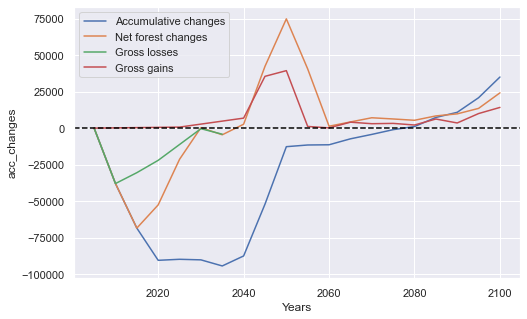

In [70]:
# plotting net and gross changes
sns.set_theme()
plt.figure(figsize=[8,5])
sns.lineplot(data=indo_refor_2005, x="Years", y="acc_changes", label="Accumulative changes")
sns.lineplot(data=indo_refor_2005, x="Years", y="net_changes", label="Net forest changes")
sns.lineplot(data=loss, x="Years", y="gross_changes", label="Gross losses")
sns.lineplot(data=gains, x="Years", y="gross_changes", label="Gross gains")
plt.axhline(0, ls='--', c="black");

In [28]:
acc_changes(df=indo_refor)

/Users/firzariany/opt/anaconda3/envs/land_1o5_2/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [29]:
gross_changes(df=indo_refor)

In [30]:
net_changes(df=indo_refor)

In [31]:
loss_ori = indo_refor.loc[indo_refor.gross_changes <= 0]
gains_ori = indo_refor.loc[indo_refor.gross_changes >= 0]

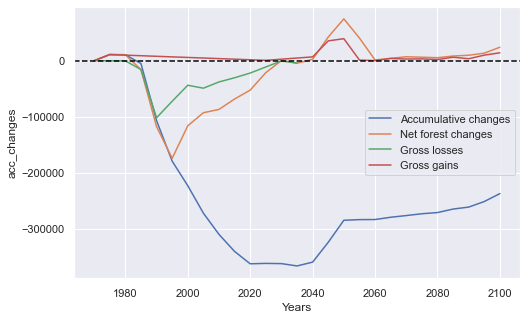

In [32]:
plt.figure(figsize=[8,5])
sns.lineplot(data=indo_refor, x="Years", y="acc_changes", label="Accumulative changes")
sns.lineplot(data=indo_refor, x="Years", y="net_changes", label="Net forest changes")
sns.lineplot(data=loss_ori, x="Years", y="gross_changes", label="Gross losses")
sns.lineplot(data=gains_ori, x="Years", y="gross_changes", label="Gross gains")
plt.axhline(0, ls='--', c="black");

## Indonesia (country) downscaling

- In this step, I'll join indo_refor_2005 with forest_idn_2005 to get the gross_changes at the regional- and country-level

### Emission downscaling

In [75]:
# join indo_refor_2005 and forest_idn_2005
loss_joint = pd.merge(loss_idn, loss, on="Years", how="inner", suffixes=("_idn", "_region"), copy=False)

In [76]:
loss_joint.head()

Region_idn      Years  Forest area (km2)_idn acc_changes_idn  \
0       INDO 2005-01-01           1.082992e+06               0   
1       INDO 2010-01-01           1.045839e+06     -37153.3125   
2       INDO 2015-01-01           1.015898e+06      -67093.625   
3       INDO 2020-01-01           9.937669e+05      -89225.125   
4       INDO 2030-01-01           9.913994e+05      -91592.625   

  gross_changes_idn net_changes_idn Region_region  Forest area (km2)_region  \
0                 0               0          INDO               1444826.875   
1       -37153.3125     -37153.3125          INDO               1406885.750   
2       -29940.3125      -67093.625          INDO               1376387.250   
3          -22131.5     -52071.8125          INDO               1354340.500   
4           -1676.0         -2367.5          INDO               1354654.250   

  acc_changes_region gross_changes_region net_changes_region  
0                  0                    0                  0  
1         -37941.125           -37941.125         -37941.125  
2         -68439.625             -30498.5         -68439.625  
3         -90486.375            -22046.75          -52545.25  
4         -90172.625              -386.25             313.75

In [77]:
# to get the ratio: (gross_changes_idn / gross_changes_region) * 100
loss_joint = loss_joint.astype({'gross_changes_region': 'float32', 'gross_changes_idn': 'float32'})

In [123]:
loss_joint["gross_changes_ratio"] = -(loss_joint["gross_changes_idn"] / loss_joint["gross_changes_region"]) * 100 

In [124]:
loss_joint.head()

Region_idn      Years  Forest area (km2)_idn acc_changes_idn  \
0       INDO 2005-01-01           1.082992e+06               0   
1       INDO 2010-01-01           1.045839e+06     -37153.3125   
2       INDO 2015-01-01           1.015898e+06      -67093.625   
3       INDO 2020-01-01           9.937669e+05      -89225.125   
4       INDO 2030-01-01           9.913994e+05      -91592.625   

   gross_changes_idn net_changes_idn Region_region  Forest area (km2)_region  \
0             0.0000               0          INDO               1444826.875   
1        -37153.3125     -37153.3125          INDO               1406885.750   
2        -29940.3125      -67093.625          INDO               1376387.250   
3        -22131.5000     -52071.8125          INDO               1354340.500   
4         -1676.0000         -2367.5          INDO               1354654.250   

  acc_changes_region  gross_changes_region net_changes_region  \
0                  0                 0.000                  0   
1         -37941.125            -37941.125         -37941.125   
2         -68439.625            -30498.500         -68439.625   
3         -90486.375            -22046.750          -52545.25   
4         -90172.625              -386.250             313.75   

   gross_changes_ratio  
0                  NaN  
1           -97.923592  
2           -98.169785  
3          -100.384415  
4          -433.915863

In [127]:
loss_joint_2 = loss_joint.loc[loss_joint["gross_changes_ratio"] > -105]

In [128]:
loss_joint_2["gross_changes_ratio"].mean()

-98.82593

### Sequestration downscaling

In [82]:
gains_joint = pd.merge(gains_idn, gains, on="Years", how="inner", suffixes=("_idn", "_region"), copy=False)

In [83]:
# gains_joint.dtypes

In [84]:
gains_joint = gains_joint.astype({'gross_changes_region': 'float32', 'gross_changes_idn': 'float32'})

In [85]:
gains_joint["gross_changes_ratio"] = (gains_joint["gross_changes_idn"] / gains_joint["gross_changes_region"]) * 100 

In [86]:
gains_joint.head()

Region_idn      Years  Forest area (km2)_idn acc_changes_idn  \
0       INDO 2005-01-01            1082992.000               0   
1       INDO 2040-01-01             992147.125      -90844.875   
2       INDO 2045-01-01            1021929.375      -61062.625   
3       INDO 2050-01-01            1058564.625      -24427.375   
4       INDO 2065-01-01            1060899.875      -22092.125   

   gross_changes_idn net_changes_idn Region_region  Forest area (km2)_region  \
0               0.00               0          INDO               1444826.875   
1            6056.50          747.75          INDO               1357328.500   
2           29782.25        35838.75          INDO               1392780.250   
3           36635.25         66417.5          INDO               1432125.750   
4            2984.00         2797.75          INDO               1437502.250   

  acc_changes_region  gross_changes_region net_changes_region  \
0                  0                 0.000                  0   
1         -87498.375              6843.250            2674.25   
2         -52046.625             35451.750            42295.0   
3         -12701.125             39345.500           74797.25   
4          -7324.625              4070.625             4222.0   

   gross_changes_ratio  
0                  NaN  
1            88.503273  
2            84.007843  
3            93.111664  
4            73.305695

In [87]:
gains_joint.shape


(12, 12)

In [88]:
gains_joint["gross_changes_ratio"].mean()


90.40492

### Net emission downscaling

In [165]:
net_joint = pd.merge(forest_idn_2005, indo_refor_2005, on=["Years", "Region"], how="inner", suffixes=("_idn", "_region"), copy=False)

In [166]:
net_joint.head(6)

Region      Years  Forest area (km2)_idn acc_changes_idn gross_changes_idn  \
0   INDO 2005-01-01           1.082992e+06               0                 0   
1   INDO 2010-01-01           1.045839e+06     -37153.3125       -37153.3125   
2   INDO 2015-01-01           1.015898e+06      -67093.625       -29940.3125   
3   INDO 2020-01-01           9.937669e+05      -89225.125          -22131.5   
4   INDO 2025-01-01           9.930754e+05      -89916.625            -691.5   
5   INDO 2030-01-01           9.913994e+05      -91592.625           -1676.0   

  net_changes_idn  Forest area (km2)_region acc_changes_region  \
0               0               1444826.875                  0   
1     -37153.3125               1406885.750         -37941.125   
2      -67093.625               1376387.250         -68439.625   
3     -52071.8125               1354340.500         -90486.375   
4        -22823.0               1355040.500         -89786.375   
5         -2367.5               1354654.250         -90172.625   

  gross_changes_region net_changes_region  
0                    0                  0  
1           -37941.125         -37941.125  
2             -30498.5         -68439.625  
3            -22046.75          -52545.25  
4                700.0          -21346.75  
5              -386.25             313.75

In [169]:
net_joint.dtypes

Region                              object
Years                       datetime64[ns]
Forest area (km2)_idn              float32
acc_changes_idn                     object
gross_changes_idn                  float32
net_changes_idn                    float32
Forest area (km2)_region           float32
acc_changes_region                  object
gross_changes_region               float32
net_changes_region                 float32
dtype: object

In [168]:
# net_changes are object, convert them to float32
net_joint = net_joint.astype({'net_changes_idn': 'float32', 'net_changes_region': 'float32',
                             'gross_changes_idn' : 'float32', 'gross_changes_region' : 'float32'})

In [170]:
# ratio
net_joint["net_ems_ratio"] = (net_joint["gross_changes_idn"] / net_joint["gross_changes_region"]) * 100 

In [173]:
net_joint_sub = net_joint.loc[(net_joint["net_ems_ratio"] <= 100) & (net_joint["net_ems_ratio"] >= -100)]

In [176]:
net_joint_sub["net_ems_ratio"].mean()

70.11341

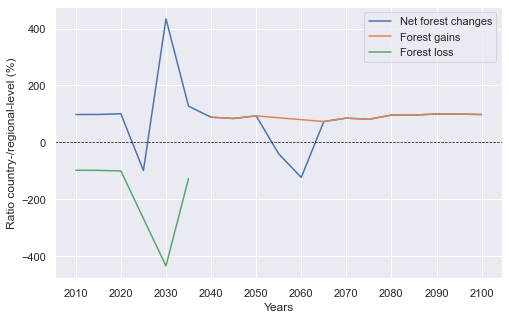

In [177]:
# plotting the trend in ratio
plt.figure(figsize=[8,5])
sns.lineplot(data=net_joint, x="Years", y="net_ems_ratio", label="Net forest changes")
sns.lineplot(data=gains_joint, x="Years", y="gross_changes_ratio", label="Forest gains")
sns.lineplot(data=loss_joint, x="Years", y="gross_changes_ratio", label="Forest loss")
plt.ylabel("Ratio country-/regional-level (%)")
plt.axhline(0, ls='--', c="black", linewidth=0.7);

there's a negative extreme in 2030. it's because in the regional level, there is a net change of +300 km2 from 2025, while in Indonesia there is a net change of -2,300 km2 from 2025. 

## PNG: downscaling

### Emission

In [130]:
# emission
loss_joint_p = pd.merge(loss_png, loss, on="Years", how="inner", suffixes=("_png", "_region"), copy=False)

In [131]:
loss_joint_p

Region_png      Years  Forest area (km2)_png acc_changes_png  \
0        PNG 2005-01-01           360872.21875               0   
1        PNG 2010-01-01           360276.06250      -596.15625   
2        PNG 2015-01-01           359764.96875        -1107.25   
3        PNG 2020-01-01           359735.90625      -1136.3125   

  gross_changes_png net_changes_png Region_region  Forest area (km2)_region  \
0                 0               0          INDO               1444826.875   
1        -596.15625      -596.15625          INDO               1406885.750   
2        -511.09375        -1107.25          INDO               1376387.250   
3          -29.0625      -540.15625          INDO               1354340.500   

  acc_changes_region gross_changes_region net_changes_region  
0                  0                    0                  0  
1         -37941.125           -37941.125         -37941.125  
2         -68439.625             -30498.5         -68439.625  
3         -90486.375            -22046.75          -52545.25

In [132]:
# to get the ratio: (gross_changes_idn / gross_changes_region) * 100
loss_joint_p = loss_joint_p.astype({'gross_changes_region': 'float32', 'gross_changes_png': 'float32'})

loss_joint_p["gross_changes_ratio"] = (loss_joint_p["gross_changes_png"] / loss_joint_p["gross_changes_region"]) * 100 

In [133]:
loss_joint_p.head()

Region_png      Years  Forest area (km2)_png acc_changes_png  \
0        PNG 2005-01-01           360872.21875               0   
1        PNG 2010-01-01           360276.06250      -596.15625   
2        PNG 2015-01-01           359764.96875        -1107.25   
3        PNG 2020-01-01           359735.90625      -1136.3125   

   gross_changes_png net_changes_png Region_region  Forest area (km2)_region  \
0            0.00000               0          INDO               1444826.875   
1         -596.15625      -596.15625          INDO               1406885.750   
2         -511.09375        -1107.25          INDO               1376387.250   
3          -29.06250      -540.15625          INDO               1354340.500   

  acc_changes_region  gross_changes_region net_changes_region  \
0                  0                 0.000                  0   
1         -37941.125            -37941.125         -37941.125   
2         -68439.625            -30498.500         -68439.625   
3         -90486.375            -22046.750          -52545.25   

   gross_changes_ratio  
0                  NaN  
1             1.571267  
2             1.675800  
3             0.131822

In [134]:
loss_joint_p["gross_changes_ratio"].mean()

1.1262962

### Sequestration

In [135]:
# sequestration
gains_joint_p = pd.merge(gains_png, gains, on="Years", how="inner", suffixes=("_png", "_region"), copy=False)

In [136]:
# to get the ratio
gains_joint_p = gains_joint_p.astype({'gross_changes_region': 'float32', 'gross_changes_png': 'float32'})

In [137]:
gains_joint_p["gross_changes_ratio"] = (gains_joint_p["gross_changes_png"] / gains_joint_p["gross_changes_region"]) * 100 

In [141]:
gains_joint_p.loc[gains_joint_p["gross_changes_ratio"] <= 100]["gross_changes_ratio"]

2     11.493077
3     15.939093
4      6.343006
7     25.963459
8     14.719993
9     20.029099
10     3.973802
11     0.432193
12     0.000000
13     0.916140
14     1.798396
Name: gross_changes_ratio, dtype: float32

In [138]:
gains_joint_p.loc[gains_joint_p["gross_changes_ratio"] <= 100]["gross_changes_ratio"].mean()

9.237114

### Net emission

In [178]:
net_joint_p = pd.merge(forest_png_2005, indo_refor_2005, on=["Years"], how="inner", suffixes=("_png", "_region"), copy=False)

In [179]:
net_joint_p.columns

Index(['Region_png', 'Years', 'Forest area (km2)_png', 'acc_changes_png',
       'gross_changes_png', 'net_changes_png', 'Region_region',
       'Forest area (km2)_region', 'acc_changes_region',
       'gross_changes_region', 'net_changes_region'],
      dtype='object')

In [181]:
# net_changes are object, convert them to float32
net_joint_p = net_joint_p.astype({'net_changes_png': 'float32', 'net_changes_region': 'float32',
                                 'gross_changes_png' : 'float32', 'gross_changes_region' : 'float32'})

In [183]:
# ratio
net_joint_p["net_ems_ratio"] = (net_joint_p["gross_changes_png"] / net_joint_p["gross_changes_region"]) * 100 

In [186]:
net_p_sub = net_joint_p.loc[(net_joint_p["net_ems_ratio"] <= 100) & (net_joint_p["net_ems_ratio"] >= -100)]

In [189]:
net_p_sub["net_ems_ratio"].mean()

5.095009

## TLS: downscaling

### Emission

In [174]:
# emission
loss_joint_t = pd.merge(loss_tls, loss, on="Years", how="inner", suffixes=("_tls", "_region"), copy=False)

In [176]:
loss_joint_t = loss_joint_t.astype({'gross_changes_region': 'float32', 'gross_changes_tls': 'float32'})

loss_joint_t["gross_changes_ratio"] = (loss_joint_t["gross_changes_tls"] / loss_joint_t["gross_changes_region"]) * 100 

In [178]:
loss_joint_t["gross_changes_ratio"].mean()

0.47149897

### Sequestration

In [179]:
# sequestration
gains_joint_t = pd.merge(gains_tls, gains, on="Years", how="inner", suffixes=("_tls", "_region"), copy=False)

In [185]:
gains_joint_t = gains_joint_t.astype({'gross_changes_region': 'float32', 'gross_changes_tls': 'float32'})

gains_joint_t["gross_changes_ratio"] = (gains_joint_t["gross_changes_tls"] / gains_joint_t["gross_changes_region"]) * 100 

In [187]:
gains_joint_t["gross_changes_ratio"].mean()

0.5463017

### Net emission

In [190]:
net_joint_t = pd.merge(forest_tls_2005, indo_refor_2005, on=["Years"], how="inner", suffixes=("_tls", "_region"), copy=False)

In [191]:
net_joint_t.head()

Region_tls      Years  Forest area (km2)_tls acc_changes_tls  \
0        TLS 2005-01-01             962.737427               0   
1        TLS 2010-01-01             770.914673     -191.822754   
2        TLS 2015-01-01             723.880859     -238.856567   
3        TLS 2020-01-01             837.756165     -124.981262   
4        TLS 2025-01-01             830.528931     -132.208496   

  gross_changes_tls net_changes_tls Region_region  Forest area (km2)_region  \
0                 0               0          INDO               1444826.875   
1       -191.822754     -191.822754          INDO               1406885.750   
2        -47.033813     -238.856567          INDO               1376387.250   
3        113.875305       66.841492          INDO               1354340.500   
4         -7.227234      106.648071          INDO               1355040.500   

  acc_changes_region gross_changes_region net_changes_region  
0                  0                    0                  0  
1         -37941.125           -37941.125         -37941.125  
2         -68439.625             -30498.5         -68439.625  
3         -90486.375            -22046.75          -52545.25  
4         -89786.375                700.0          -21346.75

In [192]:
# net_changes are object, convert them to float32
net_joint_t = net_joint_t.astype({'net_changes_tls': 'float32', 'net_changes_region': 'float32',
                                 'gross_changes_tls' : 'float32', 'gross_changes_region' : 'float32'})

In [193]:
# ratio
net_joint_t["net_ems_ratio"] = (net_joint_t["gross_changes_tls"] / net_joint_t["gross_changes_region"]) * 100 

In [195]:
net_joint_t["net_ems_ratio"].mean()

-0.09680893

# Some reminders

In [181]:
indo_refor_2005.shape

(20, 6)

In [182]:
forest_tls_2005.shape

(20, 6)

In [183]:
gains_joint_t.shape

(11, 11)

In [184]:
loss_joint_t.shape

(5, 12)